# Install ORTEGA

In [17]:
!pip install ortega

  Attempting uninstall: ortega
    Found existing installation: ortega 0.0.30
    Uninstalling ortega-0.0.30:
      Successfully uninstalled ortega-0.0.30


In [1]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [2]:
bigdata = pd.read_csv('/path/Mother_Cub1.csv', sep=',',header=0)
bigdata['Time_LMT'] = pd.to_datetime(bigdata.Time_LMT)
print('total number of gps points:', bigdata.shape[0])

total number of gps points: 10414


If locations were tracked using latitude and longitude format, users need to manually convert them to projected coordinates system (i.e., in meters) before implement ORTEGA. If the locations are already in projected coordinates system, this step can be skiped.

In [3]:
import utm 

def convert_to_projected(x, lat, lon):
    u1 = utm.from_latlon(x[lat], x[lon])
    x[lat] = u1[0]
    x[lon] = u1[1]
    return x

bigdata = bigdata.apply(lambda x: convert_to_projected(x,'latitude','longitude'), axis=1)

# Create ORTEGA object and implement interaction analysis
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In [4]:
interaction1 = ortega.ORTEGA(data=bigdata,
                             start_time='2020-01-01 00:00:00',  ##set a time window to subset data
                             end_time='2020-01-10 00:00:00',
                             minute_delay=60,
                             time_field='Time_LMT',
                             id_field='idcollar'
                             )

2023-02-14 15:46:51.490544 Initializing ORTEGA object...
2023-02-14 15:46:51.497463 Generate PPA list for the two moving entities...
2023-02-14 15:46:51.567244 Generating PPA list completed!
2023-02-14 15:46:51.630248 Initialization success!


The below cell runs interaction_analysis() and it returns three values. 
- The first value is a list of intersecting PPA pairs as paired built-in Ellipse objects.
- The second return value is a dataframe containing all intersecting PPA pairs. 
- The third return value is a dataframe that includes all identified continuous interaction segments (interaction events).

In [5]:
intersecting_ellipse_list, df_intersecting_PPAs, df_duration = interaction1.interaction_analysis()

2023-02-14 15:46:51.635058 Implement interaction analysis...
2023-02-14 15:46:51.635124 Getting spatial and temporal intersection pairs...
2023-02-14 15:46:52.199354 Getting spatial and temporal intersection pairs completed!
2023-02-14 15:46:52.199508 Complete! 243 pairs of intersecting PPAs found!
2023-02-14 15:46:52.203397 Compute duration of interaction...
2023-02-14 15:46:52.219688 Complete! 10 interaction events identified!


The beblow results indicate 10 interaction events between these two moving entities.
The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [6]:
df_duration

,No,P1,P2,Start,End,Duration
0,1,131343,229012,2020-01-01 13:00:00,2020-01-02 09:00:00,1200.0
1,2,131343,229012,2020-01-02 14:00:00,2020-01-03 09:00:00,1140.0
2,3,131343,229012,2020-01-03 12:00:00,2020-01-03 16:00:00,240.0
3,4,131343,229012,2020-01-03 18:00:00,2020-01-04 04:00:00,600.0
4,5,131343,229012,2020-01-04 05:00:00,2020-01-04 09:00:00,240.0
5,6,131343,229012,2020-01-04 10:00:00,2020-01-04 22:00:00,720.0
6,7,131343,229012,2020-01-06 04:00:00,2020-01-06 21:00:00,1020.0
7,8,131343,229012,2020-01-07 18:00:00,2020-01-08 12:00:00,1080.0
8,9,131343,229012,2020-01-08 13:00:00,2020-01-08 22:00:00,540.0
9,10,131343,229012,2020-01-09 01:00:00,2020-01-09 10:00:00,540.0


# Compute PPA size and use violin plots to show the distribution

In [7]:
ppasize_list = ortega.ppastatistics.compute_ppa_size(interaction1)

Statistics of PPA ellipses length for id 131343:
mean: 1270.177264786058
min: 24.492134849989274
max: 10249.479300467094
median: 495.94965837092207
std: 1685.2904019829357
Statistics of PPA ellipses length for id 229012:
mean: 507.2899703396009
min: 24.561605574185432
max: 8016.131427280183
median: 190.23402746535186
std: 828.332358258244


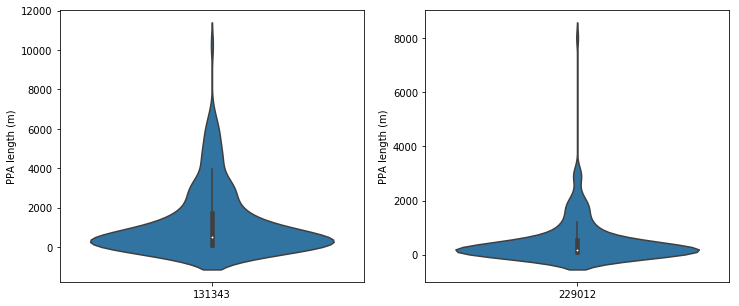

In [8]:
import seaborn
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppasize_list['size_list1'], ax=ax1)
seaborn.violinplot(data=ppasize_list['size_list2'], ax=ax2)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA length (m)')
ax2.set_ylabel('PPA length (m)')
plt.show()

# Compute PPA interval and use violin plot to show the distribution

In [9]:
interval_list = ortega.ppastatistics.compute_ppa_interval(interaction1)

Statistics of PPA ellipses time interval (minutes) for id 131343:
mean: 61.4218009478673
min: 57.0
max: 122.00000000000001
median: 60.0
std: 9.237980534737535
Statistics of PPA ellipses time interval (minutes) for id 229012:
mean: 62.30769230769231
min: 57.0
max: 300.0
median: 60.0
std: 18.547537525828538


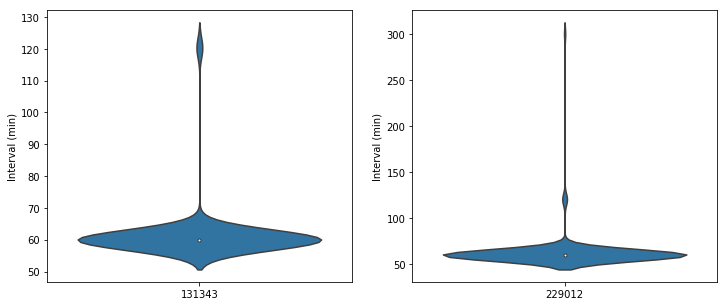

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=interval_list[0].tolist(), ax=ax1)
seaborn.violinplot(data=interval_list[1].tolist(), ax=ax2)
ax1.set_xticklabels([interaction1.id1])
ax2.set_xticklabels([interaction1.id2])
ax1.set_ylabel('Interval (min)')
ax2.set_ylabel('Interval (min)')
plt.show()

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

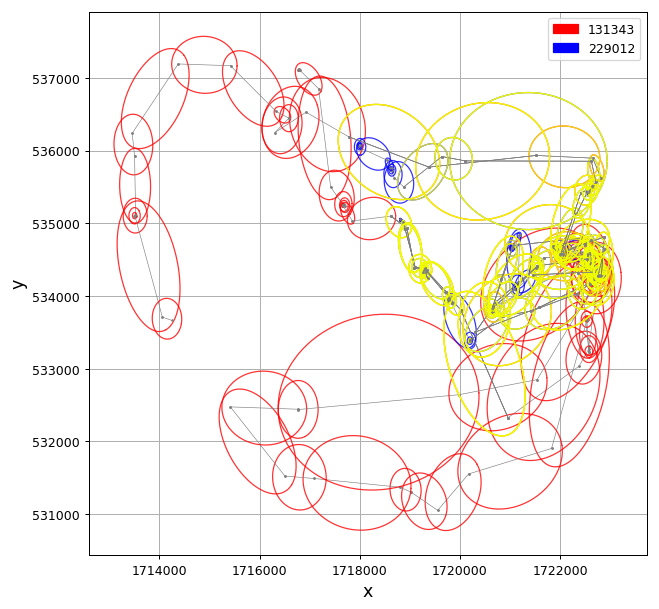

In [11]:
ortega.visualization.plot_interaction(interaction1, intersecting_ellipse_list)

map the original tracks without annotating intersecting portion

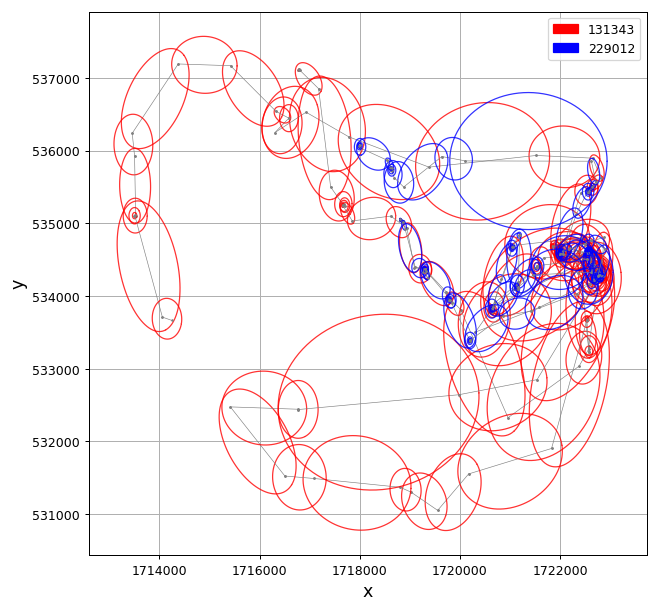

In [12]:
ortega.visualization.plot_original_tracks(interaction1) 

# Explore the difference in speed and movement  direction when individuals interact

Statistics of percentage difference in movement speed between intersecting PPAs:
count    243.000000
mean       1.023724
std        0.596991
min        0.004261
25%        0.520717
50%        1.024964
75%        1.517461
max        1.993448
Name: diff_speed, dtype: float64


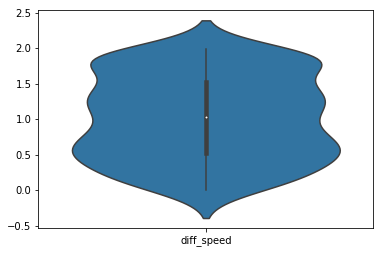

In [13]:
df_pair_speed = ortega.ppastatistics.compute_ppa_speed(df_intersecting_PPAs)
ax = seaborn.violinplot(data=df_pair_speed['diff_speed'])
ax.set_xticklabels(['diff_speed'])
plt.show()

Statistics of difference in movement direction between intersecting PPAs:
count    243.000000
mean      79.953860
std       55.730110
min        0.262960
25%       28.826498
50%       75.598809
75%      127.825488
max      178.955497
Name: diff_direction, dtype: float64


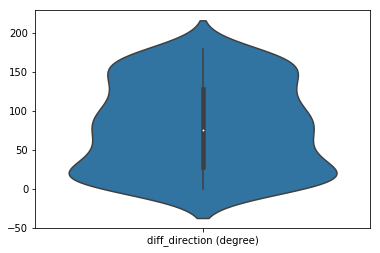

In [14]:
df_pair_angle = ortega.ppastatistics.compute_ppa_direction(df_intersecting_PPAs)
ax = seaborn.violinplot(data=df_pair_angle['diff_direction'])
ax.set_xticklabels(['diff_direction (degree)'])
plt.show()